## Реализация приложения по распознаванию номеров домов

In [ ]:
import pathlib
import os
import itertools
import re

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy.io as scio
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, Dropout, MaxPooling2D, Input, Flatten, BatchNormalization

In [3]:
def resize(img):
    new_img = Image.fromarray(img).resize((32, 32)).convert('RGB')
    return np.array(new_img)

In [4]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = keras.datasets.mnist.load_data()

x_train_mnist = np.array([resize(imge) for imge in x_train_mnist])
x_test_mnist = np.array([resize(imge) for imge in x_test_mnist])

print('Train samples:', len(x_train_mnist))
print('Test samples:', len(x_test_mnist))

Train samples: 60000
Test samples: 10000


In [25]:
model = keras.Sequential([
    Input((32, 32, 3)),
    
    Conv2D(16, kernel_size=(3, 3), padding='same'),
    Activation('elu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(32, kernel_size=(3, 3), padding='same'),
    Activation('elu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(64, kernel_size=(3, 3), padding='same'),
    Activation('elu'),
    MaxPooling2D(pool_size=2),
    
    Flatten(),
    Dropout(0.4),
    Dense(64, kernel_regularizer=keras.regularizers.l2(0.005)),
    Dropout(0.2),
    
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)         

In [21]:
def predict(model, train):
    pred = model.predict(train)
    return pred.argmax(axis=1).squeeze()


def get_error_indexes(y_test, pred):
    return np.asarray(pred != y_test.squeeze()).nonzero()[0]

In [26]:
model.fit(x_train_mnist, y_train_mnist, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 34s 571us/sample - loss: 1.0304 - acc: 0.9095
Epoch 2/5
60000/60000 [==============================] - 30s 507us/sample - loss: 0.3036 - acc: 0.9664
Epoch 3/5
60000/60000 [==============================] - 30s 499us/sample - loss: 0.1909 - acc: 0.9715
Epoch 4/5
60000/60000 [==============================] - 31s 524us/sample - loss: 0.1732 - acc: 0.9730
Epoch 5/5
60000/60000 [==============================] - 33s 549us/sample - loss: 0.1623 - acc: 0.9756


In [9]:
model.evaluate(x_test_mnist, y_test_mnist)
pred_mnist = predict(model, x_test_mnist)

10000/10000 [==============================] - 2s 185us/sample - loss: 0.1211 - acc: 0.9856


Okay, **98.2%** is not too bad.

Let's do some error analysis

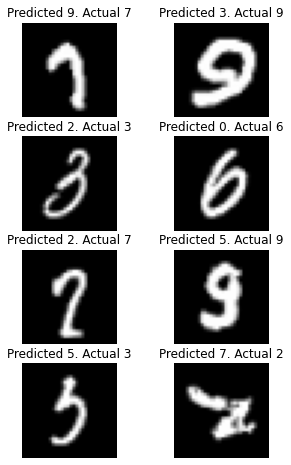

In [11]:
error_indexes = get_error_indexes(y_test_mnist, pred_mnist)

fig = plt.figure(figsize=(5, 8))
for i in range(8):
    n = np.random.choice(error_indexes, 1)
    ax = fig.add_subplot(4, 2, i + 1)
    ax.imshow(x_test_mnist[n].squeeze())
    text = f'Predicted {pred_mnist[n].squeeze()}. Actual {y_test_mnist[n].squeeze()}'
    ax.set_title(text)
    ax.axis('off')

plt.show()

In [12]:
train_raw = scio.loadmat('../blobs/train_32x32.mat')
test_raw = scio.loadmat('../blobs/test_32x32.mat')

x_train = np.moveaxis(train_raw['X'], -1, 0)
x_test = np.moveaxis(test_raw['X'], -1, 0)

y_train = train_raw['y']
y_test = test_raw['y']

x_train = x_train / 255.
x_test = x_test / 255.

y_train = y_train % 10
y_test = y_test % 10

print('Train samples:', len(x_train))
print('Test samples:', len(x_test))

Train samples: 73257
Test samples: 26032


Let's see how this model works on real-world data

In [27]:
model.evaluate(x_test, y_test)

26032/26032 [==============================] - 6s 218us/sample - loss: 2.5889 - acc: 0.1736


[2.5889128771162357, 0.17359404]

Yeah, we've only 7% above random. Synthetic data does not help much with real-world noisy pictures

In [13]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
73257/73257 [==============================] - 41s 559us/sample - loss: 1.2231 - acc: 0.6454
Epoch 2/5
73257/73257 [==============================] - 42s 577us/sample - loss: 0.7842 - acc: 0.8063
Epoch 3/5
73257/73257 [==============================] - 47s 648us/sample - loss: 0.7150 - acc: 0.8267
Epoch 4/5
73257/73257 [==============================] - 43s 586us/sample - loss: 0.6709 - acc: 0.8372
Epoch 5/5
73257/73257 [==============================] - 42s 569us/sample - loss: 0.6410 - acc: 0.8478


Even though we started with 98% accuracy on MNIST, the first epoch on this dataset still started with only around 15% accuracy and ended with 65%. The datasets are very different.

In [14]:
model.evaluate(x_test, y_test)
pred = predict(model, x_test)

26032/26032 [==============================] - 5s 197us/sample - loss: 0.5799 - acc: 0.8673


We still got **86%** in the end. There's a lot we can do to improve the accuracy, but we focus on how the model changes here.

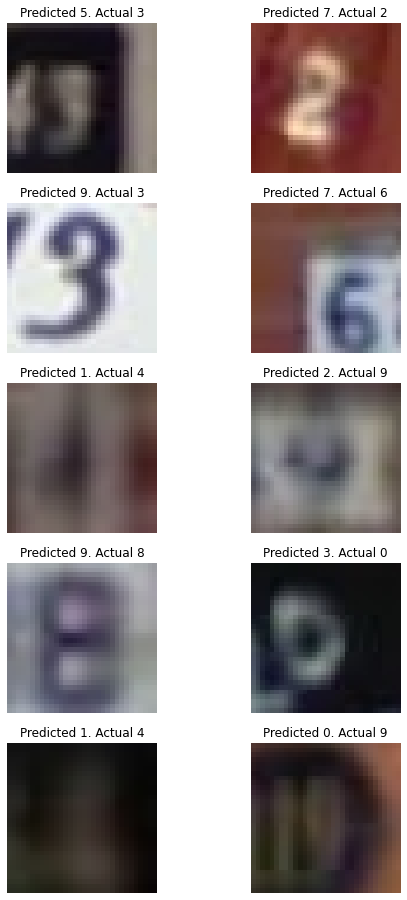

In [22]:
error_indexes = get_error_indexes(y_test, pred)

fig = plt.figure(figsize=(8, 16))
for i in range(10):
    n = np.random.choice(error_indexes, 1)
    ax = fig.add_subplot(5, 2, i + 1)
    ax.imshow(x_test[n].squeeze())
    text = f'Predicted {pred[n].squeeze()}. Actual {y_test[n].squeeze()}'
    ax.set_title(text)
    ax.axis('off')

plt.show()

Let's now try it on MNIST again!

In [24]:
score, accuracy = model.evaluate(x_test_mnist, y_test_mnist)

10000/10000 [==============================] - 2s 177us/sample - loss: 193.1044 - acc: 0.5489


Whoa, we went way down. It might be because:

- StreetView has different colors; the network might've learnt to differentiate base on that
- StreetView is much noisier, the network's learnt to disregard a lot of info

In [14]:
# TODO: object detection on original big images

In [ ]:
# TODO: plot kernels after fitting on MNIST and after fitting on StreetView